In [2]:
import sys
sys.path.append('path-to-funcs.py')
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import re
import h5py



import seaborn as sns
sns.set_palette("husl")
sns.set_style("white")
sns.set_context("poster")


%matplotlib inline

In [2]:
mice = [16102,16104,16106,16108,16109,16111]
for mouse in [16111]:#mice:
    allDaysPaths = [
        #'/Users/Stan/Desktop/firstLickSignal/16109/030617/',
        '/Users/Stan/Desktop/firstLickSignal/{}/030717/'.format(mouse),
        '/Users/Stan/Desktop/firstLickSignal/{}/030817/'.format(mouse),
        '/Users/Stan/Desktop/firstLickSignal/{}/030917/'.format(mouse),
        '/Users/Stan/Desktop/firstLickSignal/{}/031017/'.format(mouse),

    ]

    sweeps = []
    for day in allDaysPaths:
        allRunsPaths = glob(day + '*.h5')
        for path in allRunsPaths:
            with h5py.File(path) as f:
                for sweep in range(1, 61):
                    sweeps.append(f['sweep_{0:04d}/analogScans'.format(sweep)][...])
                    # or f['sweep_0008/timestamp']
            

    #Downsample Sweeps
    sampleRate = 20000
    downsampleFac = 200
    sweeps = [sweep[:,:200000][:,::downsampleFac] for sweep in sweeps]

In [ ]:
#load odor sequence for this run and which odor is being rewarded
with h5py.File('/Users/Stan/Desktop/odorList.mat', 'r') as f:
    odorSequenceThisRun =  f['odors'][...]
with h5py.File('/Users/Stan/Desktop/rewOdor.mat', 'r') as f:
    rewOdor =  f['rewOdor'][...]

In [3]:
import funcs
#funcs contains getLickTimesManySweeps and findRewardedTrials used to build the plot. 

In [671]:
firstRun = sweeps[:60]
allSweepLickTimes = getLickTimesManySweeps(firstRun)
rewards = findRewardedTrials(firstRun)

(0, 1100)

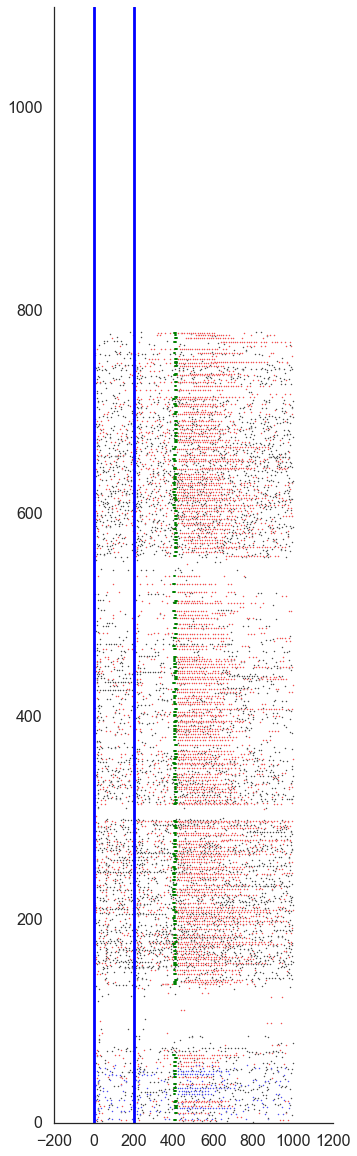

In [664]:
plt.figure(figsize = (5,20))
for sweepNum in range(len(sweeps)):
    color = 'k'
    if rewards[sweepNum]:
        color='r'
    if sweepNum in UnrewardedOdor:
        color = 'b'
        
        
    rewardTime = np.squeeze(np.argwhere(sweeps[sweepNum][1,:]>TTLThresh))
    rewardTimeThisSweep = np.array(zip(rewardTime, np.repeat(sweepNum,rewardTime.shape)))
    try:
        plt.plot(rewardTimeThisSweep[:,0],rewardTimeThisSweep[:,1], color = 'g', linewidth = 2)
    except:
        pass
    a = plt.scatter(allSweepLickTimes[sweepNum][:,0],allSweepLickTimes[sweepNum][:,1],s = 2, marker = 'o', c = color)
    sns.despine()

plt.axvline(0)
plt.axvline(200)
plt.ylim(0,1100)
#plt.savefig('/users/stan/desktop/behavior/M16102.png')

In [655]:

#Functions: 
    
def findLevels(A, level, mode='rising', boxWidth=0, rangeSubset=None):
    """Function to find level crossings in an 1d numpy array.  Based on the Igor
    function FindLevel. 

    Can find rising and/or falling crossings, control with the 'mode' paramter.

    Returns an numpy array of all crossings found and the number of crossings

    :param A: 1d numpy array
    :param level: floating point to search for in A
    :param mode: optional string: mode specfication. one of 'rising', 'falling' or 'both'
    :param boxWidth: optional int for local boxcar smoothing
    :param rangeSubset: optional list of ints to limit the search
    :returns: tuple, a numpy array of level crossings and the number of crossings
    """
    assert mode in ('rising', 'falling', 'both'), 'traceManip.findLevels: Unknown mode \'%s\'' % mode

    if boxWidth is not 0:
        A = np.convolve(A, np.array([1]*boxWidth)/float(boxWidth))

    crossings = np.diff(np.sign(A-level), axis=0)
    
    if mode is 'rising':
        rising_points = np.where(crossings > 0)
        return rising_points[0], len(rising_points[0])
    elif mode is 'falling':
        falling_points = np.where(crossings < 0)
        return falling_points[0], len(falling_points[0])
    else:
        all_crossing_points = np.where(np.abs(crossings) > 0)
        return all_crossing_points, len(all_crossing_points)
